In [8]:
# ---- Imports ----
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

# ---- Step 1: Load MNIST ----
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# ---- Step 2: Define Simple MLP ----
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# ---- Step 3: Training Loop ----
def train_one_epoch(epoch):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(trainloader)
    print(f"Epoch {epoch} loss: {avg_loss}")
    return avg_loss

# ---- Step 4: Spectrum Extraction ----
def get_spectrum(weight_matrix):
    w = weight_matrix.detach().cpu().numpy()
    s = la.svdvals(w)  # singular values
    eigvals = s**2 / w.shape[1]  # eigenvalues
    return eigvals

# ---- Step 5: Marchenko–Pastur PDF ----
def marchenko_pastur_pdf(x, q, sigma2=1.0):
    lambda_min = sigma2 * (1 - np.sqrt(1/q))**2
    lambda_max = sigma2 * (1 + np.sqrt(1/q))**2
    pdf = np.zeros_like(x)
    mask = (x >= lambda_min) & (x <= lambda_max)
    pdf[mask] = (1/(2*np.pi*sigma2*x[mask]*q)) * np.sqrt((lambda_max-x[mask])*(x[mask]-lambda_min))
    return pdf

# ---- Step 6: Plot and Save Spectrum ----
def plot_with_mp(eigvals, layer_name, epoch):
    plt.hist(eigvals, bins=80, density=True, alpha=0.5, label="Empirical ESD")
    x = np.linspace(min(eigvals), max(eigvals), 200)
    q = len(eigvals) / model.fc1.in_features
    plt.plot(x, marchenko_pastur_pdf(x, q), 'r-', lw=2, label="Marchenko–Pastur Law")
    plt.title(f"{layer_name}: Spectrum vs MP law (Epoch {epoch})")
    plt.legend()
    plt.savefig(f"spectrum_epoch_{epoch}.png", dpi=300, bbox_inches="tight")
    plt.close()

# ---- Step 7: Run Training & Collect Spectra ----
epochs = 5
losses = []
top_eigs = []

for epoch in range(epochs):
    # Train
    epoch_loss = train_one_epoch(epoch)
    losses.append(epoch_loss)

    # Extract spectrum
    eigvals_fc1 = get_spectrum(model.fc1.weight)
    top_val = np.sort(eigvals_fc1)[-1]
    top_eigs.append(top_val)

    print(f"Epoch {epoch}: Top 5 eigenvalues of fc1: {np.sort(eigvals_fc1)[-5:]}")
    plot_with_mp(eigvals_fc1, "fc1", epoch)

# ---- Step 8: Plot Loss Curve ----
plt.plot(range(epochs), losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.savefig("loss_curve.png", dpi=300, bbox_inches="tight")
plt.close()

# ---- Step 9: Plot Top Eigenvalue Evolution ----
plt.plot(range(epochs), top_eigs, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Top Eigenvalue")
plt.title("Top Eigenvalue Evolution")
plt.savefig("top_eigs_evolution.png", dpi=300, bbox_inches="tight")
plt.close()


Epoch 0 loss: 0.730184632133065
Epoch 0: Top 5 eigenvalues of fc1: [0.00144643 0.00171677 0.00209373 0.00227371 0.00233312]
Epoch 1 loss: 0.3629381599456771
Epoch 1: Top 5 eigenvalues of fc1: [0.00170255 0.00207919 0.00253159 0.00290086 0.00294555]
Epoch 2 loss: 0.31831241556322143
Epoch 2: Top 5 eigenvalues of fc1: [0.00186229 0.00231339 0.00281991 0.00328832 0.00337182]
Epoch 3 loss: 0.2910588043791526
Epoch 3: Top 5 eigenvalues of fc1: [0.00200601 0.00252074 0.00307151 0.00361156 0.00369494]
Epoch 4 loss: 0.2687937352480665
Epoch 4: Top 5 eigenvalues of fc1: [0.00213651 0.00269836 0.00326889 0.00386343 0.00397437]


C:\Users\mdsan
['loss_curve.png', 'spectrum_epoch_0.png', 'spectrum_epoch_1.png', 'spectrum_epoch_10.png', 'spectrum_epoch_15.png', 'spectrum_epoch_19.png', 'spectrum_epoch_2.png', 'spectrum_epoch_3.png', 'spectrum_epoch_4.png', 'spectrum_epoch_5.png', 'top_eigs_evolution.png']


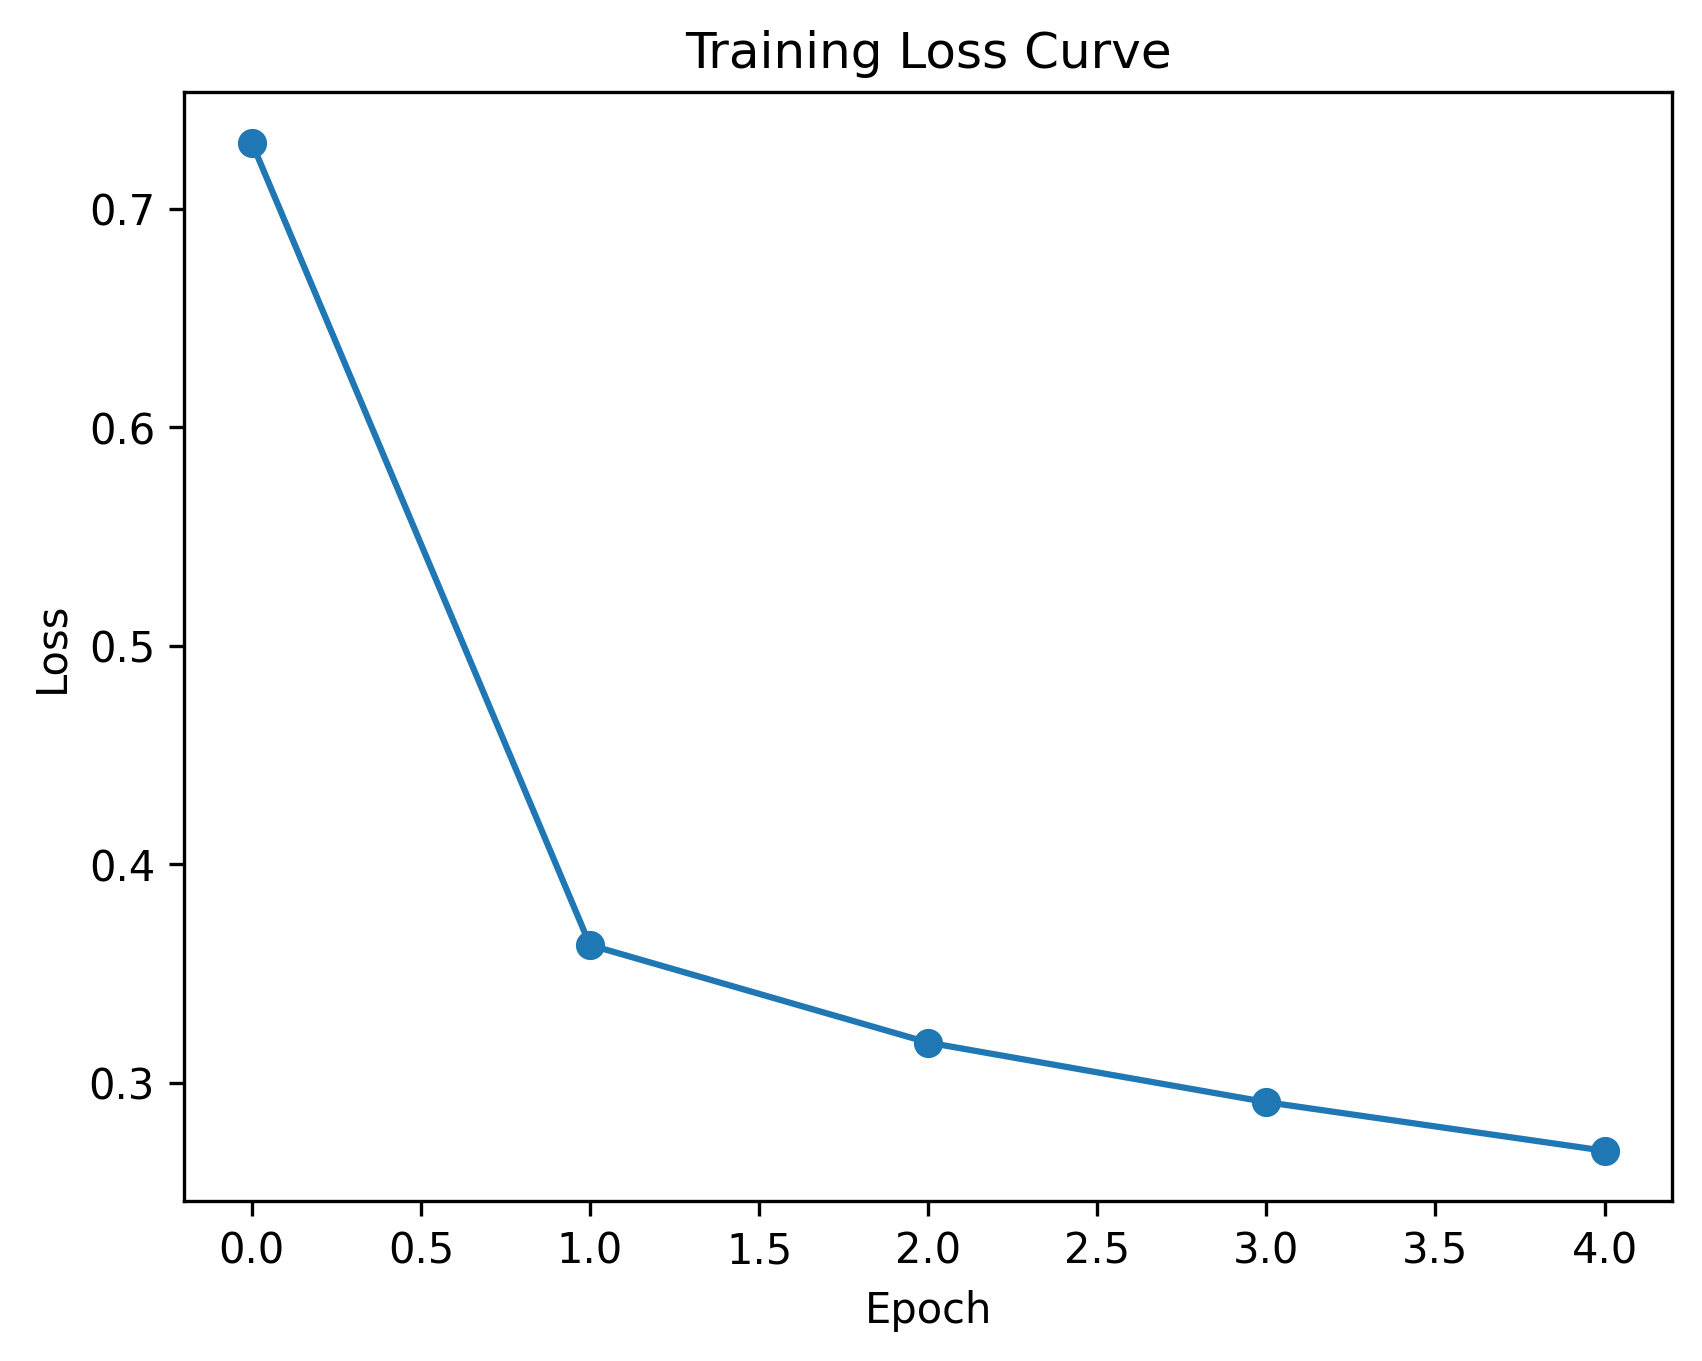

In [14]:
import os
print(os.getcwd())
import glob
print(glob.glob("*.png"))
from IPython.display import Image

# Example: show the loss curve
Image(filename="loss_curve.png")


In [3]:
# ---- Training + Spectral Analysis ----
num_epochs = 20
all_losses = []
top_eigs_per_epoch = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(trainloader)
    all_losses.append(epoch_loss)

    # --- Spectral analysis for fc1 ---
    W = model.fc1.weight.detach().numpy()
    cov = np.dot(W, W.T) / W.shape[1]  # covariance-like matrix
    eigvals = np.linalg.eigvalsh(cov)  # eigenvalues
    eigvals = eigvals[eigvals > 1e-8]  # filter numerical noise
    eigvals.sort()

    # Store top 5 eigenvalues
    top_eigs_per_epoch.append(eigvals[-5:])

    # --- Plot histogram + MP law every 5 epochs ---
    if epoch % 5 == 0 or epoch == num_epochs - 1:
        q = W.shape[0] / W.shape[1]
        sigma2 = np.var(W)
        lam_plus = sigma2 * (1 + np.sqrt(1/q))**2
        lam_minus = sigma2 * (1 - np.sqrt(1/q))**2
        mp = lambda x: np.sqrt((lam_plus - x) * (x - lam_minus)) / (2 * np.pi * sigma2 * q * x)

        xs = np.linspace(lam_minus, lam_plus, 200)
        plt.figure(figsize=(6,4))
        plt.hist(eigvals, bins=50, density=True, alpha=0.6, label="Empirical ESD")
        plt.plot(xs, mp(xs), 'r-', lw=2, label="Marchenko–Pastur Law")
        plt.title(f"fc1 Spectrum vs MP law (Epoch {epoch})")
        plt.legend()
        plt.savefig(f"spectrum_epoch_{epoch}.png")
        plt.close()

    print(f"Epoch {epoch} loss: {epoch_loss:.4f}, Top eigenvalues: {eigvals[-5:]}")

# ---- Final plots ----

# Loss curve
plt.figure(figsize=(6,4))
plt.plot(all_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("loss_curve.png")
plt.close()

# Top eigenvalues evolution
top_eigs_per_epoch = np.array(top_eigs_per_epoch)
plt.figure(figsize=(6,4))
for i in range(5):
    plt.plot(top_eigs_per_epoch[:, i], label=f"Eig {i+1}")
plt.title("Top Eigenvalues Evolution (fc1)")
plt.xlabel("Epoch")
plt.ylabel("Eigenvalue")
plt.legend()
plt.savefig("top_eigs_evolution.png")
plt.close()



Epoch 0 loss: 0.2516, Top eigenvalues: [0.00232411 0.0027773  0.00354927 0.00403632 0.00426272]
Epoch 1 loss: 0.2338, Top eigenvalues: [0.00243124 0.00292909 0.0037434  0.0042289  0.00445527]
Epoch 2 loss: 0.2172, Top eigenvalues: [0.00253172 0.00304456 0.00389114 0.00442447 0.00460934]
Epoch 3 loss: 0.2033, Top eigenvalues: [0.00262529 0.0031864  0.00406309 0.00458438 0.00477147]
Epoch 4 loss: 0.1904, Top eigenvalues: [0.00270422 0.0032979  0.00421773 0.00472822 0.00491395]
Epoch 5 loss: 0.1787, Top eigenvalues: [0.00281161 0.00342344 0.00435841 0.00487382 0.00502658]
Epoch 6 loss: 0.1685, Top eigenvalues: [0.00292487 0.00353638 0.00447787 0.00501064 0.00513691]
Epoch 7 loss: 0.1596, Top eigenvalues: [0.00303597 0.00365003 0.00460716 0.00512691 0.00523732]
Epoch 8 loss: 0.1507, Top eigenvalues: [0.00315349 0.00376057 0.0047186  0.00524732 0.00535328]
Epoch 9 loss: 0.1433, Top eigenvalues: [0.00326587 0.00388328 0.00484076 0.00535287 0.00546485]
Epoch 10 loss: 0.1365, Top eigenvalues: 